In [6]:
import pandas as pd
from google.cloud import bigquery
import numpy as np
import pickle
import gpflow
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
from gpflow.utilities import print_summary
import download_airnow_web
import pyproj
from scipy.optimize import curve_fit
import networkx as nx
from calibration.errormetrics import MAE, MSE, NMSE, NLPD, compute_test_data
from calibration.simple import compute_simple_calibration,compute_simple_predictions, plot_simple_calibration_graph
%matplotlib inline

# Loading data and preparing

Building two simple numpy matrices: X and Y.
X has three columns:
Time (in hours since 15th July, 2020), SensorA, SensorB
Y has two columns, the two measurements.
(I combine the two sensors on the AirQo units).
(Only use data since 15th July).


In [7]:
df = pickle.load(open('alldataprocessed_embassycopy.p','rb'))
encounters = pickle.load(open('encounters_embassycopy.p','rb'))

unq = df['channel_id'].unique()
print("Number of encounters: %d" % len(encounters))

keep = np.all((encounters[['pm2_5_sensorA','s2_pm2_5_sensorB']]>10) & (encounters[['pm2_5_sensorA','s2_pm2_5_sensorB']]<300),1)
encounters = encounters[keep]
print("Number of encounters after removing outliers: %d" % len(encounters))

################################
#GROUP AVERAGE OUR DATA INTO 30 MIN CHUNKS
temp = []
for sidA in np.unique(encounters['channel_id_sensorA']):
    for sidB in np.unique(encounters['channel_id_sensorB']):
        enc = encounters[(encounters['channel_id_sensorA']==sidA) & (encounters['channel_id_sensorB']==sidB)]
        if (sidA==930432) & (sidB==-24517):
            print(enc)
        enc=enc.dropna(how='any',subset=['pm2_5_sensorA','pm2_5_sensorB'])
        
        if len(enc)<1:
            continue   
            
        temp.append(enc.resample('30T',on='created_at').mean().dropna(how='any',subset=['pm2_5_sensorA','pm2_5_sensorB']))
    
encounters = pd.concat(temp) 
encounters['created_at']=encounters.index
print("Number of encounters after averaging: %d" % len(encounters))

################################
#BUILDING X AND Y (average the two sensors in each unit)
t = (encounters['created_at']-pd.Timestamp('2020-07-15',tz='UTC')).dt.total_seconds()/3600 #hours since 15th July
idA = [np.where(a==unq)[0][0] for a in encounters['channel_id_sensorA']]
idB = [np.where(a==unq)[0][0] for a in encounters['channel_id_sensorB']]
sA = np.nanmean(encounters[['pm2_5_sensorA','s2_pm2_5_sensorA']],1)
sB = np.nanmean(encounters[['pm2_5_sensorB','s2_pm2_5_sensorB']],1)
X = np.c_[t,idA,idB]
Y = np.c_[sA,sB]
#This makes it so the smaller id is always first in the pair
swaps = X[:,2]<X[:,1]
X[swaps,1],X[swaps,2] = X[swaps,2],X[swaps,1]
Y[swaps,1],Y[swaps,0] = Y[swaps,0],Y[swaps,1]

################################
#FOR PLOTTING we build a network
import networkx as nx
G = nx.DiGraph()
for ia,idA in enumerate(unq):
    for idB in unq[ia:]:
        s = np.sum((encounters['channel_id_sensorA']==idA) & (encounters['channel_id_sensorB']==idB))+np.sum((encounters['channel_id_sensorA']==idB) & (encounters['channel_id_sensorB']==idA))
        if s>20:
            G.add_edge(idA,idB,weight=s)
for e in G.edges:
    G.edges[e]['w']=np.sqrt(G.edges[e]['weight'])
    
################################
#SET REFRERNCE SENSOR
#refsensor = (unq<0).astype(int)
refsensor = (unq==-24516).astype(int)
refsensor

################################
print("Data ranges from %s to %s" % (str(np.min(df['created_at'])),str(np.max(df['created_at']))))

Number of encounters: 443515
Number of encounters after removing outliers: 243460
Number of encounters after averaging: 20748
Data ranges from 2020-07-15 00:00:16+00:00 to 2021-02-03 21:00:00+00:00


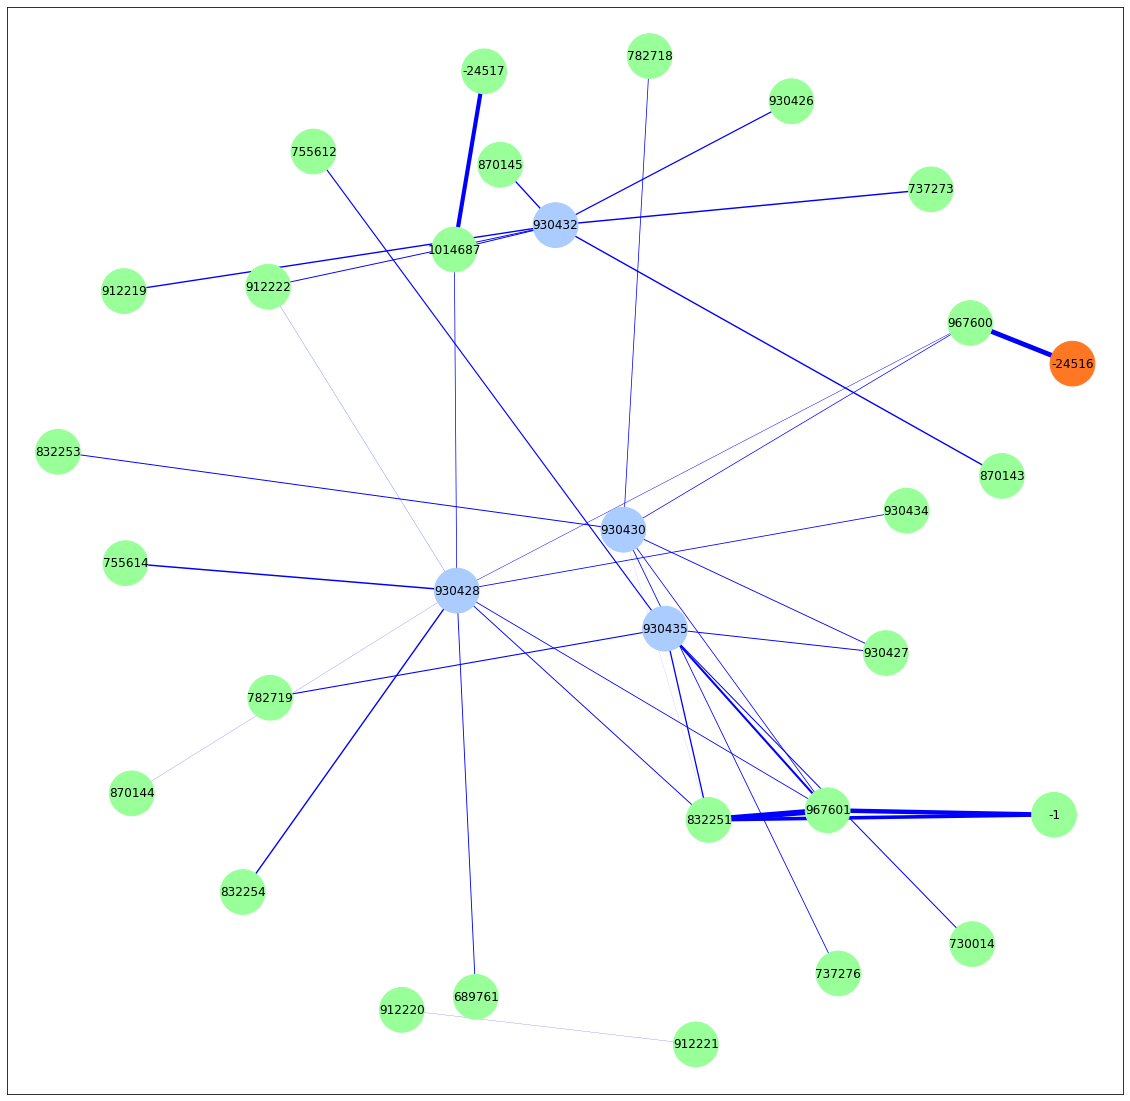

In [8]:
################################
#PLOT THE GRAPH

plt.figure(figsize=[20,20])
weights = np.array([G.get_edge_data(*e)['weight'] for e in G.edges()])
widths = np.log(weights)-np.min(np.log(weights))#(500*weights)/np.max(weights)
#widths[widths>10]=10
mobile = [np.mean(np.abs(np.diff(df[df['channel_id']==sid]['x'])))>10 for sid in unq]

cols = []
for n in G.nodes:
    c = '#99ff99'
    idx = np.where(unq==n)[0][0]
    if refsensor[idx]: c = '#ff7722'
    if mobile[idx]: c = '#aaccff'
    cols.append(c)

nx.draw_networkx(G,pos=nx.spring_layout(G,k=2,weight='w'),arrows=False,width=widths,edge_color='blue',node_color=cols,node_size=2000)
plt.savefig('network.pdf')

In [9]:
encounters

,channel_id_sensorA,pm2_5_sensorA,s2_pm2_5_sensorA,latitude_sensorA,longitude_sensorA,temperature_sensorA,humidity_sensorA,x_sensorA,y_sensorA,channel_id_sensorB,pm2_5_sensorB,s2_pm2_5_sensorB,latitude_sensorB,longitude_sensorB,temperature_sensorB,humidity_sensorB,x_sensorB,y_sensorB,dist,created_at
created_at,,,,,,,,,,,,,,,,,,,,
2020-11-04 07:30:00+00:00,-24517.0,42.400000,NaN,0.331705,32.60986,NaN,NaN,3.630113e+06,36925.437963,930428.0,20.900000,23.000000,0.331743,32.609535,0.000000,27749.0,3.630077e+06,36929.668174,36.425304,2020-11-04 07:30:00+00:00
2020-10-24 11:30:00+00:00,-24517.0,22.000000,NaN,0.331705,32.60986,NaN,NaN,3.630113e+06,36925.437963,930432.0,36.000000,21.000000,0.331697,32.609505,52.000000,0.0,3.630073e+06,36924.547392,39.528453,2020-10-24 11:30:00+00:00
2020-11-01 09:30:00+00:00,-24517.0,21.300000,NaN,0.331705,32.60986,NaN,NaN,3.630113e+06,36925.437963,930432.0,16.000000,12.000000,0.331553,32.610046,42.000000,0.0,3.630134e+06,36908.517117,26.740039,2020-11-01 09:30:00+00:00
2020-11-04 07:30:00+00:00,-24517.0,42.400000,NaN,0.331705,32.60986,NaN,NaN,3.630113e+06,36925.437963,930432.0,39.700000,36.900000,0.331629,32.609669,38.000000,0.0,3.630092e+06,36916.977540,22.883452,2020-11-04 07:30:00+00:00
2020-11-06 10:00:00+00:00,-24517.0,47.400000,NaN,0.331705,32.60986,NaN,NaN,3.630113e+06,36925.437963,930432.0,65.100000,63.000000,0.331729,32.609512,34.000000,0.0,3.630074e+06,36928.109675,38.831203,2020-11-06 10:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-10 05:00:00+00:00,1014687.0,88.587500,89.164167,0.331705,32.60986,34.500000,0.0,3.630113e+06,36925.437963,930432.0,82.483333,74.541667,0.331626,32.609648,29.000000,0.0,3.630089e+06,36916.606469,25.285960,2021-01-10 05:00:00+00:00
2021-01-22 14:30:00+00:00,1014687.0,65.215000,65.227000,0.331705,32.60986,42.100000,0.0,3.630113e+06,36925.437963,930432.0,60.610000,55.640000,0.331615,32.609704,35.200000,0.0,3.630096e+06,36915.452437,25.736913,2021-01-22 14:30:00+00:00
2021-01-22 15:00:00+00:00,1014687.0,60.716667,60.300000,0.331705,32.60986,42.000000,0.0,3.630113e+06,36925.437963,930432.0,59.400000,52.333333,0.331656,32.609799,35.000000,0.0,3.630106e+06,36920.020324,27.791677,2021-01-22 15:00:00+00:00


In [10]:
#TO RUN THE REAL DATA EXPERIMENT USE THE FIRST OPTION THAT USES A NEARBY LOW-COST SENSOR
#FOR THE SYNTHETIC DRIFT OPTION SELECT THE SECOND OPTION, AND ADD DRIFT STEP
use_ref_sensor_with_drift = True
##########################################
#OPTION: using 1014687 which is next to 24517 as test sensor.
if not use_ref_sensor_with_drift:
    temp = []
    for sA,sB in [['B','A'],['A','B']]:
        tempdf = encounters[(encounters['channel_id_sensor'+sA]==1014687) & (encounters['channel_id_sensor'+sB]==-24517)]
        tempdf['t'] = (tempdf['created_at']-pd.Timestamp('2020-07-15',tz='UTC')).dt.total_seconds()/3600
        temp.append(tempdf[['t','pm2_5_sensor'+sA,'pm2_5_sensor'+sB]].to_numpy())
    temp = np.r_[temp[0],temp[1]]
    temp = temp[np.min(temp[:,1:],1)>5,:]

    testX = np.c_[temp[:,0],np.full_like(temp[:,0],np.where(unq==1014687)[0][0])]
    testY = temp[:,1:2]
    testtrueY = temp[:,2:3]

##########################################
#OPTION: Using -24517 as the test sensor and add drift.
if use_ref_sensor_with_drift:
    testsensordf = df[df['channel_id']==-24517]
    t = (testsensordf['created_at']-pd.Timestamp('2020-07-15',tz='UTC')).dt.total_seconds()/3600 #hours since 15th July
    testX = np.c_[t,t]
    testX[:,1]=np.where(unq==-24517)[0][0]
    testY = testsensordf['pm2_5'].to_numpy()[:,None]
    testtrueY = testY.copy()

##########################################
#Strim our test data to just 1/10th
testY=testY[::10,:]
testtrueY=testtrueY[::10,:]
testX = testX[::10,:]

##########################################
##########################################
#ADD DRIFT
if use_ref_sensor_with_drift:
    idx = np.where(unq==-24517)[0][0]
    Y[X[:,2]==idx,1]*=(1+(X[X[:,2]==idx,0]-1590)/2000)
    testY[testX[:,1]==idx,0]*=(1+(testX[testX[:,1]==idx,0]-1590)/2000)

##########################################
#PLOT DRIFT
#plt.figure()
#plt.plot(X[X[:,2]==idx,0],(1+(X[X[:,2]==idx,0]-1590)/2000),'.-')
#print("Added drift scale from %0.2f to %0.2f" % (np.min((1+(X[X[:,2]==idx,0]-1590)/2000)),np.max((1+(X[X[:,2]==idx,0]-1590)/2000))))

##########################################
#Mobile ids
mobile = np.array([832255, 930428, 930430, 930431, 930432, 930435])

In [11]:
######################################################
#PLOT encounters over time
#plt.figure(figsize=[20,4])
#plt.vlines(X[:,0],X[:,1],X[:,2])
#plt.xlim([2500.0,2550.0])
#plt.hlines(np.arange(len(unq)),-1000,5000,'g',alpha=0.4)
#plt.hlines(np.where(refsensor),-1000,5000,'b')
#plt.hlines([np.where(unq==m)[0][0] for m in mobile],-1000,5000,'r')
#plt.vlines(np.arange(0,3000,24),-4,20,'grey',alpha=0.5)
##plt.ylim([-0.5,13.5])
#plt.yticks(np.arange(50),np.arange(50));
#plt.xticks(np.arange(int(2500/24)*24,2550,24),np.arange(int(2500/24)*24,2550,24).astype(int))
#plt.ylabel('Sensor')
#plt.xlabel('Time / hours')
#plt.savefig('kampalavisits.pdf')

# Simple Method

## Find good delta and weight...

In [12]:
#once this is done once, we have just made a record of the best choice
#from networkx import NodeNotFound
#from calibration.simple import compute_simple_calibration, compute_simple_predictions
#bestcomb = None
#bestnmse = np.inf
#for weightovertime in np.logspace(-2,2,10,base=np.e):
#    for delta in np.logspace(np.log(24*1),np.log(24*200),20,base=np.e):
#        G,allsp,allcals,allcallists,allpopts,allpcovs,allpoptslists = compute_simple_calibration(X,Y,delta,refsensor,weightovertime=weightovertime,mincolocationsinperiod=1)
#        preds,res2,res = compute_simple_predictions(testX,testY,testtrueY,allcals,delta)
#        nmse = NMSE(testtrueY[:,0],preds[:,0])
#        if nmse<bestnmse:
#            bestnmse=nmse
#            bestcomb = (weightovertime,delta)
#        print("%5.2f, %5.2f %5.3f" % (weightovertime,delta,nmse))
#print(bestcomb,bestnmse)

In [13]:
#best choice from above
delta = 24
weightovertime = 0.211
G,allsp,allcals,allcallists,allpopts,allpcovs,allpoptslists = compute_simple_calibration(X,Y,delta,refsensor,weightovertime=weightovertime,mincolocationsinperiod=1)

/home/mike/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/mike/Documents/Research/calibration/calibration/simple.py:86: RuntimeWarning: invalid value encountered in log
  allpopts[s] = np.sum(np.log([G.get_edge_data(u,v)['popt'] for u,v in zip(allsp[s][:-1],allsp[s][1:])]),0)
/home/mike/Documents/Research/calibration/calibration/simple.py:86: RuntimeWarning: divide by zero encountered in log
  allpopts[s] = np.sum(np.log([G.get_edge_data(u,v)['popt'] for u,v in zip(allsp[s][:-1],allsp[s][1:])]),0)


In [14]:
preds,res2,res = compute_simple_predictions(testX,testY,testtrueY,allcals,delta)

(0.0, 200.0)

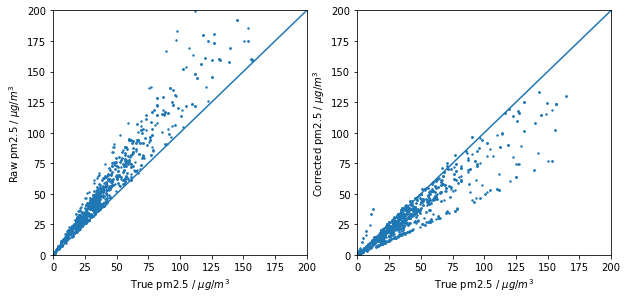

In [15]:
plt.figure(figsize=[10,4.5])
plt.subplot(1,2,1)
plt.ylabel('Raw pm2.5 / $\mu g/m^3$')
plt.xlabel('True pm2.5 / $\mu g/m^3$')
plt.scatter(testtrueY,testY[:,0],2)
plt.plot([0,200],[0,200])
plt.xlim([0,200])
plt.ylim([0,200])
plt.subplot(1,2,2)
plt.ylabel('Corrected pm2.5 / $\mu g/m^3$')
plt.xlabel('True pm2.5 / $\mu g/m^3$')
plt.scatter(testtrueY,preds[:,0],2)
plt.plot([0,200],[0,200])
plt.xlim([0,200])
plt.ylim([0,200])

In [17]:
print("Corrected:")
nmse = NMSE(testtrueY[:,0],preds[:,0])
mse = MSE(testtrueY[:,0],preds[:,0])
mae = MAE(testtrueY[:,0],preds[:,0])
print("nmse=%5.5f mse=%5.2f mae=%5.2f" % (nmse,mse,mae))

print("Raw:")
nmse = NMSE(testtrueY[:,0],testY[:,0])
mse = MSE(testtrueY[:,0],testY[:,0])
mae = MAE(testtrueY[:,0],testY[:,0])
print("nmse=%5.5f mse=%5.2f mae=%5.2f" % (nmse,mse,mae))

Corrected:
nmse=0.18044 mse=199.40 mae= 8.67
Raw:
nmse=0.32091 mse=354.63 mae=12.71


In [19]:
#temp: Just looking at effect of averaging on the MAE...
#print(MAE(np.mean(testtrueY.reshape(165//5,5),0),np.mean(preds[:,0].reshape(165//5,5),0)))
#print(MAE(np.mean(testtrueY.reshape(165//5,5),0),np.mean(testY[:,0].reshape(165//5,5),0)))

In [21]:
Ttotal = np.max(X[:,0])
Ttotal = 100*int(1+(Ttotal+1)/100)

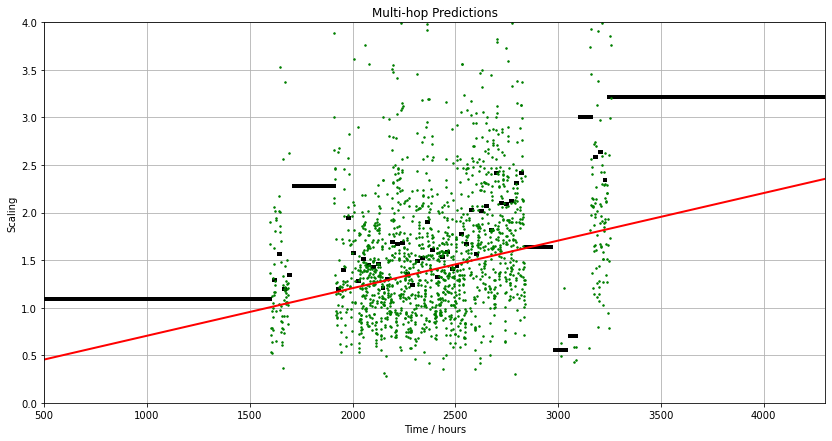

In [22]:
x = np.linspace(0,Ttotal,160)

#plt.figure(figsize=[40,40])
plt.figure(figsize=[14,7])
pltn=1
for si,refs in enumerate(refsensor):
    if refs: continue
    if unq[si]!=-24517: continue
    #plt.subplot(10,5,pltn)
    pltn+=1
    for i,t in enumerate(np.arange(0,np.max(X[:,0]),delta)):
        try:
            plt.hlines(1/(np.exp(allcals[(si,i)])),t,t+delta,lw=4)
        except KeyError:            
            pass
    senseX = ((X[:,1]==si) & refsensor[X[:,2].astype(int)]).astype(bool)
    #print(senseX)
    #print(X[senseX,0],Y[senseX,0]/Y[senseX,1])
    plt.plot(X[senseX,0],Y[senseX,0]/Y[senseX,1],'xr',markersize=12,mew=1)
    senseX = ((X[:,2]==si) & refsensor[X[:,1].astype(int)]).astype(bool)
    #print(X[senseX,0],Y[senseX,1]/Y[senseX,0])
    plt.plot(X[senseX,0],Y[senseX,1]/Y[senseX,0],'xr',markersize=12,mew=1)
    
    
    senseX = (X[:,1]==si)
    plt.plot(X[senseX,0],Y[senseX,0]/Y[senseX,1],'.g',markersize=3)
    senseX = (X[:,2]==si)
    plt.plot(X[senseX,0],Y[senseX,1]/Y[senseX,0],'.g',markersize=3)    
    #plotbars(np.arange(0,np.max(X[:,0]),delta),delta,np.exp(allscales[:,si]),'y')
    plt.ylim([0,4])
    plt.xlim([500,4300])
    #plt.yscale('log')
    plt.grid()
    #plt.text(0,0,"%d--%d" %(si,unq[si]))
    #if unq[si]==-24517:
    #    plt.plot(x,(1+(x-1590)/2000),'r-',lw=2)
    if pltn>=9:
        plt.xlabel('Time / hours')
    if pltn%2==0:
        plt.ylabel('Scaling')
    plt.xlabel('Time / hours')
    plt.title('Multi-hop Predictions')
    plt.plot(x,(1+(x-1590)/2000),'r-',lw=2)
plt.savefig('kampala_timeseries_simple.pdf')

(0.0, 1800.0)

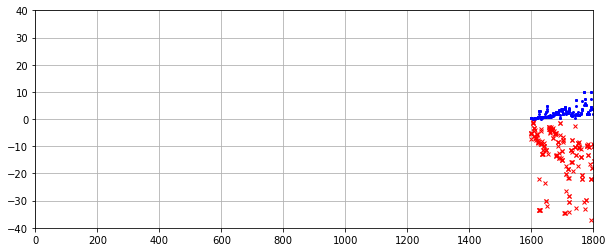

In [23]:
import numpy as np
plt.figure(figsize=[10,4])
keep = ~np.isnan(preds[:,0])
#plt.plot(testX[keep,0],testtrueY[keep,0],'.b',markersize=1)
plt.plot(testX[keep,0],testY[keep,0]-testtrueY[keep,0],'b.',markersize=4)
plt.plot(testX[keep,0],preds[keep,0]-testtrueY[keep,0],'rx',markersize=4)
plt.ylim([-40,40])
plt.grid()
plt.xlim([0,1800])

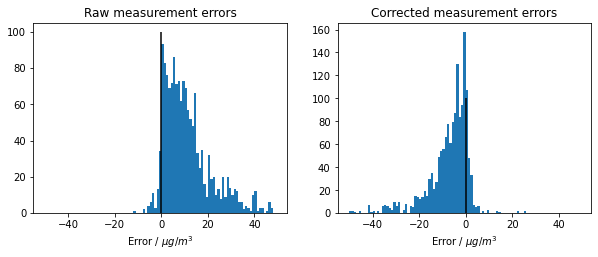

In [24]:
if use_ref_sensor_with_drift:
    s = 100
else:
    s = 10
plt.figure(figsize=[10,3.5])
plt.subplot(1,2,1)
plt.hist(testY[:,0]-testtrueY[:,0],np.arange(-50,50));
plt.title('Raw measurement errors')
plt.xlabel('Error / $\mu g/m^3$')
plt.vlines(0,0,s)
plt.subplot(1,2,2)
plt.hist(preds[:,0]-testtrueY[:,0],np.arange(-50,50));
plt.vlines(0,0,s)
plt.title('Corrected measurement errors')
plt.xlabel('Error / $\mu g/m^3$')
plt.savefig('correctingA.pdf')

In [25]:
#plot_simple_calibration_graph(G)

# Same but using VI method

In [26]:
import numpy as np
from calibration import CalibrationSystem, SparseModel
import gpflow
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
from calibration.errormetrics import MAE, MSE, NMSE, NLPD, compute_test_data
from calibration.synthetic import generate_synthetic_dataset, getstaticsensortranform, getmobilesensortranform

In [27]:
#from tensorflow_probability import distributions as tfd
#class CalibrationSystemNormalisedLikelihood(CalibrationSystem):    
#    def likelihoodfn(self,scaledA,scaledB,ref):
#        likelihoodstd = np.sqrt((self.likelihoodstd**2)*np.sum(1-ref,1))
#        return tfd.Normal(0,likelihoodstd).log_prob((scaledA-scaledB)/(0.5*(scaledA+scaledB)))


In [28]:
Ttotal = np.max(X[:,0])
Ttotal = 100*int(1+(Ttotal+1)/100)

## Run VI lots of times, to get averages...

In [29]:
for randomrestarts in range(1): #need to use more randomrestarts in paper
    var = 1
    print("------")
    for runlength in [300]:
        Z = np.linspace(-200,Ttotal+200,10)[:,None] ##60
        def transform_fn(samps,Y,sideY):
            return Y*tf.exp(samps[:,:,0:1])
        
        def transform_fn_loggrad(samps,Y,sideY):
            return samps[:,:,0:1]

        kernelindices = [[0]*len(unq)]

        #this seems to work ok.
        k = gpflow.kernels.RBF(var,24*100) + gpflow.kernels.Bias(var)
        #k = gpflow.kernels.Bias(3)
        
        cs = CalibrationSystem(X, Y, Z, refsensor, 1, transform_fn, transform_fn_loggrad, [k], kernelindices,lr=0.01,likelihoodstd=1.0,hstd=30,minibatchsize=100)
        #cs = CalibrationSystemNormalisedLikelihood(X, Y, Z, refsensor, 1, transform_fn, [k], kernelindices,lr=0.05,likelihoodstd=np.sqrt(0.2),minibatchsize=100)
        import time
        before = time.time()
        print("Starting Run")
        elbo_record = cs.run(runlength,samples=300)#,verbose=True) ##3000 iterations, 300 samples
        print(time.time()-before)


        #the test matrix is TIME,SENSOR,COMPONENT
        tX = np.c_[testX,np.full(len(testX),0)]
        testsm = SparseModel(tX,cs.Z,1,cs.k)
        #testsm = SparseModel(tX,cs.Z,1,cs.k)
        qf_mu,qf_cov = testsm.get_qf(cs.mu,cs.scale)
        predY = transform_fn(qf_mu[None,:,:],testY[:,0:1],None).numpy()[:,:,0].T
        #predY[predY>100]=100

        nlpd = NLPD(np.log(testtrueY[:,0]),np.log(testY[:,0:1])+qf_mu[:,0],np.sqrt(np.diag(qf_cov)))
        keep = ~np.isnan(testtrueY)
        nmse = NMSE(testtrueY[:,0],predY[:,0])
        mse = MSE(testtrueY[:,0],predY[:,0])
        mae = MAE(testtrueY[:,0],predY[:,0])
        #print("runlength=%d" % runlength)
        print("var=%0.1f" % var)
        print("nlpd=%5.2f nmse=%5.5f mse=%5.2f mae=%5.2f" % (nlpd,nmse,mse,mae))
        print(elbo_record[-1])

------
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.
Starting Run
285.7410559654236
var=1.0
nlpd=  nan nmse=0.04851 mse=53.60 mae= 4.93
286830.97


<ipython-input-29-d5acb5f207cc>:35: RuntimeWarning: invalid value encountered in log
  nlpd = NLPD(np.log(testtrueY[:,0]),np.log(testY[:,0:1])+qf_mu[:,0],np.sqrt(np.diag(qf_cov)))


In [30]:
#temp, exploring effect of averaging on the MAE
#print(MAE(np.mean(testtrueY.reshape(165//5,5),0),np.mean(preds[:,0].reshape(165//5,5),0)))

In [29]:
#record from a previous run.
mae=[4.01,4.48,5.90,7.85,12.33,3.66,9.18,4.32,4.88,5.11,4.44,5.48,6.68,6.40,5.03,5.01,5.59,3.78,3.41,3.36]
nmse=[0.05299,0.03292,0.07484,0.13916,0.23886,0.05396,0.13715,0.05075,0.03672,0.08456,0.06649,0.09136,0.09751,0.08393,0.05627,0.05308,0.07997,0.03973,0.04370,0.04441]

In [32]:
np.mean(mae),np.std(mae)/np.sqrt(20), np.mean(nmse), np.std(nmse)/np.sqrt(20)

(5.545, 0.4746311725961538, 0.07791800000000002, 0.010540819147485643)

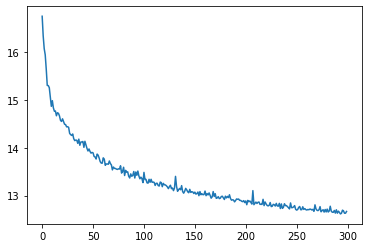

In [22]:
plt.plot(np.log(elbo_record))

In [23]:
#nmse=0.02763 mse=73.09 mae= 5.52

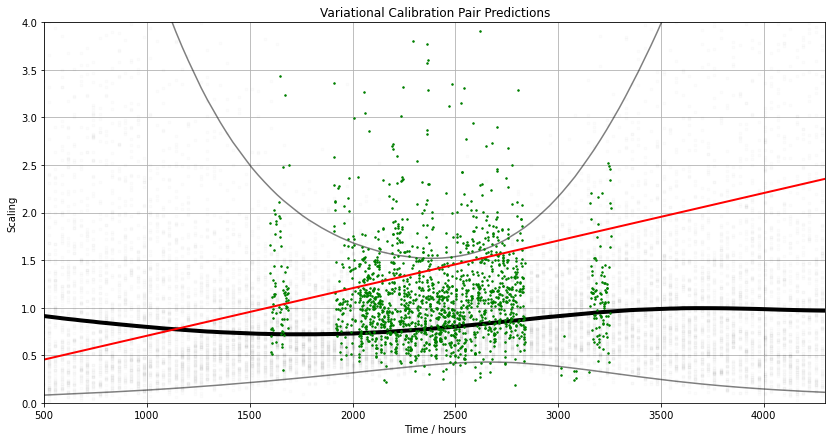

In [51]:
C = 1
for si,refs in enumerate(refsensor):
    if si!=47: continue
    if refs: continue
    x = np.linspace(0,Ttotal,160)
    plottestX = np.zeros([0,3])
    for ci in range(C):
        tempX = np.c_[x,np.ones_like(x)*si,np.full_like(x,ci)]
        plottestX = np.r_[plottestX,tempX]#.astype(int)
    testsm = SparseModel(plottestX,cs.Z,C,cs.k)
    qf_mu,qf_cov = testsm.get_qf(cs.mu,cs.scale)
    if cs.mulike is not None:
        qf_mulike,qf_covlike = testsm.get_qf(cs.mulike,cs.scalelike)
        sampslike = testsm.get_samples_one_sensor(cs.mulike,cs.scalelike)
    samps = testsm.get_samples_one_sensor(cs.mu,cs.scale)
    
    plt.figure(figsize=[14,7])
    plt.title("Variational Calibration Pair Predictions")#[si,refs])
    plt.plot(x,1/tf.exp(qf_mu[:,0]),'k-',lw=4)
    plt.plot(x,1/np.exp(samps[:,:,0].numpy().T),'k.',alpha=0.01);
    
    plt.plot(x,1/tf.exp((qf_mu[:,0]+2*np.sqrt(np.diag(qf_cov)[:]))),'k-',alpha=0.5)
    plt.plot(x,1/tf.exp((qf_mu[:,0]-2*np.sqrt(np.diag(qf_cov)[:]))),'k-',alpha=0.5)

    #senseX = (X[:,1]==si)# & (X[:,2]<Nrefs)
    #plt.plot(X[senseX,0],Y[senseX,0]/Y[senseX,1],'xg',markersize=7,mew=3) 
    #senseX = (X[:,2]==si)# & (X[:,1]<Nrefs)
    #plt.plot(X[senseX,0],Y[senseX,1]/Y[senseX,0],'xg',markersize=7,mew=3)
    senseX = (X[:,1]==si)
    plt.plot(X[senseX,0],Y[senseX,0]/Y[senseX,1],'.g',markersize=3)
    senseX = (X[:,2]==si)
    plt.plot(X[senseX,0],Y[senseX,1]/Y[senseX,0],'.g',markersize=3)    
    #plotbars(np.arange(0,np.max(X[:,0]),delta),delta,np.exp(allscales[:,si]),'y')
    plt.ylim([0,4])
    plt.grid()
    plt.ylabel('Scaling')
    plt.xlabel('Time / hours')
    plt.xlim([500,4300])
    plt.plot(x,(1+(x-1590)/2000),'r-',lw=2)
plt.savefig('timeseries_variational_kampala.pdf')

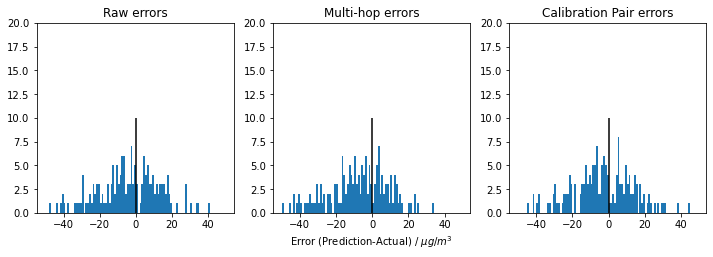

In [56]:
h = 10
r=50
plt.figure(figsize=[12,3.5])
plt.subplot(1,3,1)
plt.hist(testY[:,0]-testtrueY[:,0],np.arange(-r,r,1));
plt.title('Raw errors')
plt.ylim([0,h*2])
#plt.xlabel('Error / $\mu g/m^3$')
plt.vlines(0,0,h)
plt.subplot(1,3,2)
plt.hist(preds[:,0]-testtrueY[:,0],np.arange(-r,r,1));
plt.vlines(0,0,h)
plt.title('Multi-hop errors')
plt.ylim([0,h*2])
plt.xlabel('Error (Prediction-Actual) / $\mu g/m^3$')
plt.subplot(1,3,3)
plt.hist(predY[:,0]-testtrueY[:,0],np.arange(-r,r,1));
plt.vlines(0,0,h)
plt.title('Calibration Pair errors')
plt.ylim([0,h*2])
#plt.xlabel('Error / $\mu g/m^3$')


plt.savefig('correcting_kampala.pdf')